### 1. 保存TFRecords文件

reference: [1](https://github.com/seanyuner/tensorflow-tutorial/blob/master/Chapter07%20%E5%9B%BE%E5%83%8F%E6%95%B0%E6%8D%AE%E5%A4%84%E7%90%86/7.1%20TFRecord%E8%BE%93%E5%85%A5%E6%95%B0%E6%8D%AE%E6%A0%BC%E5%BC%8F.ipynb)、[2](http://www.machinelearninguru.com/deep_learning/tensorflow/basics/tfrecord/tfrecord.html)

In [1]:
import tensorflow as tf
import numpy as np
from random import shuffle
import cv2
import glob
import os

# 设定相关参数
IMG_HIGHT = 224
IMG_WIDTH = 224
NUM_CHANNELS = 3
SHUFFLE_DATA = True
path_to_data = './datasets/flower_photos'

CLASSES_NAMES = os.listdir(path_to_data)
NUM_CLASSES = len(CLASSES_NAMES)
NUM_EXAMPLES = sum([len(os.listdir(path_to_data + '/' + i)) for i in CLASSES_NAMES])

# 读取和划分数据集
addrs = glob.glob(path_to_data + '/*/*.jpg')
labels = []    # 通过下面循环写成one-hot形式
for i in range(NUM_CLASSES):
    label = [0 for _ in range(i)] + [1] + [0 for _ in range(NUM_CLASSES - 1 - i)]
    for j in range(len(os.listdir(path_to_data + '/' + CLASSES_NAMES[i]))):
        labels.append(label)
    
if SHUFFLE_DATA:
    c = list(zip(addrs, labels))
    shuffle(c)
    addrs, labels = zip(*c)
    
train_addrs = addrs[:int(0.75*NUM_EXAMPLES)]
train_labels = labels[:int(0.75*NUM_EXAMPLES)]
test_addrs = addrs[int(0.75*NUM_EXAMPLES):]
test_labels = labels[int(0.75*NUM_EXAMPLES):]


# 生成字符串型的属性
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

# 将数据转化为tf.train.Example格式
def _make_example(label, image):
    # 先将numpy.ndarray型的label和image转换成字符串
    label_string = label.tostring()
    image_string = image.tostring()
    example = tf.train.Example(features=tf.train.Features(feature={
        'label': _bytes_feature(label_string),
        'image': _bytes_feature(image_string)
    }))
    return example

# 读取图片
def load_image(addr):
    img = cv2.imread(addr)
    img = cv2.resize(img, (IMG_HIGHT, IMG_WIDTH), interpolation=cv2.INTER_CUBIC)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   # cv2默认为BGR格式
    return img.astype(np.float32)


# 输出包含训练数据的TFRecord文件
with tf.python_io.TFRecordWriter(path='./flowers_train.tfreocrds') as writer:
    for i in range(len(train_addrs)):
        image = load_image(train_addrs[i])
        label = np.array(train_labels[i])   # list转换成numpy.ndarray便于tostring
        # 将一个样例转化为Example Protocol Buffer，并将所有的信息写入这个数据结构
        example = _make_example(label, image)
        # 将一个Example写入TFRecord文件
        writer.write(example.SerializeToString())
print("TFRecord训练文件已保存。")

# 输出包含测试数据的TFRecord文件
with tf.python_io.TFRecordWriter(path='./flowers_test.tfreocrds') as writer:
    for i in range(len(test_addrs)):
        image = load_image(test_addrs[i])
        label = np.array(test_labels[i])
        example = _make_example(label, image)
        writer.write(example.SerializeToString())
print("TFRecord训练文件已保存。")

TFRecord训练文件已保存。
TFRecord训练文件已保存。


### 2. 读取TFRecords文件初探
**method1：队列+多线程**

reference: [1](http://www.machinelearninguru.com/deep_learning/tensorflow/basics/tfrecord/tfrecord.html)、[2](https://github.com/seanyuner/tensorflow-tutorial/blob/master/Chapter07%20%E5%9B%BE%E5%83%8F%E6%95%B0%E6%8D%AE%E5%A4%84%E7%90%86/7.3%20%E5%A4%9A%E7%BA%BF%E7%A8%8B%E8%BE%93%E5%85%A5%E6%95%B0%E6%8D%AE%E5%A4%84%E7%90%86%E6%A1%86%E6%9E%B6.ipynb)

Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.


d:\python3\tfgpu\dl+\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


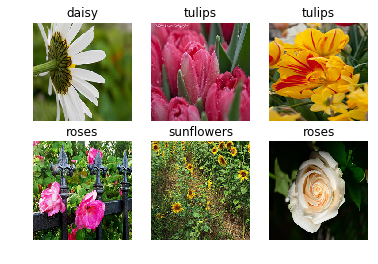

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os

# 设定相关参数
IMG_HIGHT = 224
IMG_WIDTH = 224
NUM_CHANNELS = 3
BATCH_SIZE = 32
path_to_data = './datasets/flower_photos'
CLASSES_NAMES = os.listdir(path_to_data)
NUM_CLASSES = len(CLASSES_NAMES)

# tf.train.match_filenames_once可正则匹配多个TFRecoreds文件，作为下面输入列表
filename_queue = tf.train.string_input_producer(['./flowers_train.tfreocrds'], 
                                                num_epochs=10)

reader = tf.TFRecordReader()
_, serialized_example = reader.read(filename_queue)

features = tf.parse_single_example(serialized_example, 
                                 features = {
                                     'image':tf.FixedLenFeature([], tf.string), 
                                     'label':tf.FixedLenFeature([], tf.string)
                                 })

image = tf.decode_raw(features['image'], tf.float32)
image = tf.reshape(image, [IMG_HIGHT, IMG_WIDTH, NUM_CHANNELS])
# 可自定义预处理函数
# image = _augment_helper(image)
label = tf.decode_raw(features['label'], tf.int32)
label = tf.reshape(label, [NUM_CLASSES,])

# 此处由于在写入TFrecords已经shuffle过，这里不必使用shuffule_batch
images, labels = tf.train.batch([image, label], batch_size=BATCH_SIZE, 
                                num_threads=1, capacity=100, 
                                allow_smaller_final_batch=True)

with tf.Session() as sess:
    sess.run(tf.local_variables_initializer())
    
    # tf.train.Coordinator来协同多个线程一起停止
    # 另外可以适用tf.train.QueueRunner来启动多个线程操作同一队列
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    
    for i in range(4):
        img, lab = sess.run([images, labels])
        img = img.astype(np.uint8)
        
        for j in range(6):
            plt.subplot(2, 3, j+1)
            plt.imshow(img[j, ...])
            plt.title(CLASSES_NAMES[np.argmax(lab[j])])
            plt.axis('off')
    
    coord.request_stop()
    coord.join(threads)

**method2: tf.data**

reference: [1](https://github.com/seanyuner/tensorflow-tutorial/blob/master/Chapter07%20%E5%9B%BE%E5%83%8F%E6%95%B0%E6%8D%AE%E5%A4%84%E7%90%86/7.4%20%E6%95%B0%E6%8D%AE%E9%9B%86.ipynb)

d:\python3\tfgpu\dl+\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


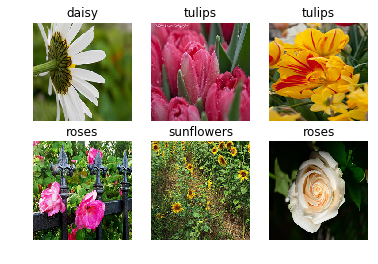

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os

# 设定相关参数
IMG_HIGHT = 224
IMG_WIDTH = 224
NUM_CHANNELS = 3
NUM_CLASSES = 5
BATCH_SIZE = 32

path_to_data = './datasets/flower_photos'
CLASSES_NAMES = os.listdir(path_to_data)
NUM_CLASSES = len(CLASSES_NAMES)

# 解析单条数据
def parser(record):
    features = tf.parse_single_example(
        record,
        features={
            'image':tf.FixedLenFeature([], tf.string),
            'label':tf.FixedLenFeature([], tf.string)
        })
    image = tf.decode_raw(features['image'], tf.float32)
    image = tf.reshape(image, [IMG_HIGHT, IMG_WIDTH, NUM_CHANNELS])   
    label = tf.decode_raw(features['label'], tf.int32)
    label = tf.reshape(label, [NUM_CLASSES,])
    
    return image, label

# 从TFRecord文件创建数据集。这里可以提供多个文件。
train_files = ["./flowers_train.tfreocrds"]
dataset = tf.data.TFRecordDataset(train_files)

# map函数表示对数据集中的每一条数据进行调用解析方法。使用TFRecordDataset读出的
# 是二进制的数据，这里需要通过map来调用parser对二进制数据进行解析。类似地，
# map函数也可以用来完成其他的数据预处理工作。
dataset = dataset.map(parser)

# 设定batch_size，此处也可通过dataset.shuffle实现shuffle，但本文件无需
dataset = dataset.batch(BATCH_SIZE)

# 数据集重复次数，间接指定训练轮数
dataset = dataset.repeat(10)

# 定义遍历数据集的迭代器。
iterator = dataset.make_initializable_iterator()

# 读取数据，可用于进一步计算
images, labels = iterator.get_next()

with tf.Session() as sess:
    sess.run(iterator.initializer)
    
    for i in range(4):
        img, lab = sess.run([images, labels])
        img = img.astype(np.uint8)
        
        for j in range(6):
            plt.subplot(2, 3, j+1)
            plt.imshow(img[j, ...])
            plt.title(CLASSES_NAMES[np.argmax(lab[j])])
            plt.axis('off')

### 3. 建立AlexNet模型

reference: [1](https://github.com/tensorflow/models/blob/master/tutorials/image/alexnet/alexnet_benchmark.py)、[2](https://github.com/kratzert/finetune_alexnet_with_tensorflow/blob/master/alexnet.py)、[3](https://www.cs.toronto.edu/~frossard/vgg16/vgg16.py)

AlexNet网络模型见[alexnet.py](./alexnet.py)文件

### 4. 实际训练
**method1: 队列+多线程**

In [1]:
import tensorflow as tf
import numpy as np
import os
from time import time
from alexnet import AlexNet

# 神经网络相关的参数
BATCH_SIZE = 128
NUM_STEPS = 600
LEARNING_RATE_BASE = 1e-4
LEARNING_RATE_DECAY = 0.99
REGULARIZATION_RATE = 0.01
MOVING_AVERAGE_DECAY = 0.99
KEEP_PROB = 0.5
DISPLAY_GAP = 50

# 训练数据相关的参数
IMG_HIGHT = 224
IMG_WIDTH = 224
NUM_CHANNELS = 3
TEST_RATIO = 0.25
path_to_data = './datasets/flower_photos'
CLASSES_NAMES = os.listdir(path_to_data)
NUM_CLASSES = len(CLASSES_NAMES)
NUM_EXAMPLES = sum([len(os.listdir(path_to_data + '/' + i)) for i in CLASSES_NAMES])
# NUM_EPOCHES = NUM_STEPS * BATCH_SIZE // int((1 - TEST_RATIO) * NUM_EXAMPLES)

# 保存日志相关的参数
WRITE_LOG = False
PATH_TO_LOG = './log/flowers_info_method1.log'


# 训练函数
def train(train_img, train_lab, test_img, test_lab):
    #  输入数据的命名空间。
    with tf.name_scope('input'):
        x = tf.placeholder(tf.float32, [None, IMG_HIGHT, IMG_WIDTH, NUM_CHANNELS], 
                           name='x-input')
        y_ = tf.placeholder(tf.float32, [None, NUM_CLASSES], name='y-input')
        keep_prob = tf.placeholder(tf.float32)
    regularizer = tf.contrib.layers.l2_regularizer(REGULARIZATION_RATE)
    model = AlexNet(x, NUM_CLASSES, keep_prob, regularizer)
    y = model.fc8
    global_step = tf.Variable(0, trainable=False)
    
    # 处理滑动平均的命名空间。
    with tf.name_scope("moving_average"):
        variable_averages = tf.train.ExponentialMovingAverage(MOVING_AVERAGE_DECAY, 
                                                              global_step)
        variables_averages_op = variable_averages.apply(tf.trainable_variables())
   
    # 计算损失函数的命名空间。
    with tf.name_scope("loss_function"):
#         cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=y, labels=y_)
        cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=y, 
                                                                       labels=tf.argmax(y_, -1))
        cross_entropy_mean = tf.reduce_mean(cross_entropy)
        loss = cross_entropy_mean + tf.add_n(tf.get_collection('losses'))
    
    # 定义学习率、优化方法及每一轮执行训练的操作的命名空间。
    with tf.name_scope("train_step"):
        learning_rate = tf.train.exponential_decay(
            LEARNING_RATE_BASE,
            global_step,
            NUM_EXAMPLES / BATCH_SIZE,
            LEARNING_RATE_DECAY,
            staircase=True)

        train_step = tf.train.AdamOptimizer(learning_rate=learning_rate)\
                     .minimize(loss, global_step=global_step)

        with tf.control_dependencies([train_step, variables_averages_op]):
            train_op = tf.no_op(name='train')
            
    # 定义准确率
    with tf.name_scope("evaluation"):
        correct_pred = tf.equal(tf.argmax(y, -1), tf.argmax(y_, -1))
        evaluation_step = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
            
    # 将当前计算图中输出到TensorBoard日志文件
    if WRITE_LOG: writer = tf.summary.FileWriter(PATH_TO_LOG, tf.get_default_graph())
    
    # 训练模型。
    with tf.Session() as sess:
        sess.run((tf.global_variables_initializer(), 
                  tf.local_variables_initializer()))
        
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(sess=sess, coord=coord)

        for i in range(NUM_STEPS):
            train_images, train_labels = sess.run([train_img, train_lab])
            train_images = train_images.astype(np.uint8)

            sess.run(train_op, feed_dict={x: train_images,
                                          y_: train_labels, 
                                          keep_prob: KEEP_PROB})

            # 每DISPLAY_GAP代，在训练集上测试一遍准确率，并保存日志
            if i== 0 or i % DISPLAY_GAP == 0:
                if WRITE_LOG:
                    # 配置运行时需要记录的信息
                    run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
                    # 运行时记录运行信息的proto
                    run_metadata = tf.RunMetadata()
                    loss_train, acc_train = sess.run([loss, evaluation_step],
                                                     feed_dict={x: train_images,
                                                                y_: train_labels, 
                                                                keep_prob: 1.0},
                                                     options=run_options, 
                                                     run_metadata=run_metadata)
                    writer.add_run_metadata(run_metadata=run_metadata, 
                                            tag=("tag%d" % i), 
                                            global_step=i)
                else:
                    loss_train, acc_train = sess.run([loss, evaluation_step], 
                                                     feed_dict={x: train_images, 
                                                                y_: train_labels, 
                                                                keep_prob: 1.0})
                print("After %04d training step(s), on training batch: loss is %g, accuracy is %g." 
                          % (i, loss_train, acc_train))
            
        # 运行测试数据，检验最终loss和acc
        test_images, test_labels = sess.run([test_img, test_lab])
        test_images = test_images.astype(np.uint8)
        loss_test, acc_test = sess.run([loss, evaluation_step], 
                                       feed_dict={x: test_images, 
                                                  y_: test_labels,
                                                  keep_prob: 1.0})
        print("Final result on testing batch: loss is %g, accuracy is %g." 
                          % (loss_test, acc_test))
        
        coord.request_stop()
        coord.join(threads)
    
    if WRITE_LOG: writer.close()
    
    
# 获取训练和测试数据
def get_data(paths, training=True):
    # 可以使用tf.train.match_filenames_once来正则匹配多个TFRecoreds文件，作为下面输入列表
    # 这里也可设定num_epochs参数来间接指定训练代数，try except OutOfRange，见method2
#     num_epochs = NUM_EPOCHES if training else 1  
    filename_queue = tf.train.string_input_producer(paths)

    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)

    features = tf.parse_single_example(serialized_example, 
                                       features = {
                                           'image':tf.FixedLenFeature([], tf.string), 
                                           'label':tf.FixedLenFeature([], tf.string)
                                       })

    image = tf.decode_raw(features['image'], tf.float32)
    image = tf.reshape(image, [IMG_HIGHT, IMG_WIDTH, NUM_CHANNELS])
    # image = _augment_helper(image)   # 可自定义预处理函数
    label = tf.decode_raw(features['label'], tf.int32)
    label = tf.reshape(label, [NUM_CLASSES,])

    # 此处由于在写入TFrecords已经shuffle过，这里不必使用shuffule_batch
    if training:
        images, labels = tf.train.batch([image, label], 
                                        batch_size=BATCH_SIZE, 
                                        num_threads=1, 
                                        capacity=1000, 
                                        allow_smaller_final_batch=True)
    else:
        images, labels = tf.train.batch([image, label], 
                                        batch_size=int(TEST_RATIO*NUM_EXAMPLES), 
                                        num_threads=1, 
                                        capacity=int(TEST_RATIO*NUM_EXAMPLES))
    return images, labels

    
# 主函数
def main(argv=None):
    train_x, train_y = get_data(['./flowers_train.tfreocrds'])
    test_x, test_y = get_data(['./flowers_test.tfreocrds'], False)
    
    start = time()
    train(train_x, train_y, test_x, test_y)
    print("Method1 running time on 600 steps without logs: %ds." % int(time() - start))
    # with log: 386s.
    
if __name__ == '__main__':
    tf.app.run()

Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
After 0000 training step(s), on training batch: loss is 30.3531, accuracy is 0.257812.
After 0050 training step(s), on training batch: loss is 16.3954, accuracy is 0.5.
After 0100 training step(s), on training batch: loss is 9.89823, accuracy is 0.601562.
After 0150 training step(s), on training batch: loss is 6.4465, accuracy is 0.609375.
After 0200 training step(s), on training batch: loss is 4.52224, accuracy is 0.726562.
After 0250 training step(s), on training batch: loss is 3.28913, accuracy is 0.820312.
After 0300 training step(s), on training batch: loss is 2.58806, accuracy is 0.8125.
After 0350 training step(s), on training batch: loss is 2.11612, accuracy is 0.84375.
After 0400 training step(s), on training batch: loss is 1.81064,

SystemExit: 

d:\python3\tfgpu\dl+\lib\site-packages\IPython\core\interactiveshell.py:2918: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


**method2：tf.data**  

In [1]:
import tensorflow as tf
import numpy as np
import os
from time import time
from alexnet import AlexNet

# 神经网络相关的参数
BATCH_SIZE = 128
NUM_STEPS = 600   # 由于下面的NUM_EPOCHES计算有整除，实际会有些许差异
LEARNING_RATE_BASE = 1e-4
LEARNING_RATE_DECAY = 0.99
REGULARIZATION_RATE = 0.01
MOVING_AVERAGE_DECAY = 0.99
KEEP_PROB = 0.5
DISPLAY_GAP = 50

# 训练数据相关的参数
IMG_HIGHT = 224
IMG_WIDTH = 224
NUM_CHANNELS = 3
TEST_RATIO = 0.25
PATHS_TO_TRAIN_TFRECORDS = ['./flowers_train.tfreocrds']
PATHS_TO_TEST_TFRECORDS = ['./flowers_test.tfreocrds']
PATH_TO_DATA = './datasets/flower_photos'
CLASSES_NAMES = os.listdir(PATH_TO_DATA)
NUM_CLASSES = len(CLASSES_NAMES)
NUM_EXAMPLES = sum([len(os.listdir(PATH_TO_DATA + '/' + i))
                    for i in CLASSES_NAMES])
NUM_EPOCHES = NUM_STEPS * BATCH_SIZE // int((1 - TEST_RATIO) * NUM_EXAMPLES)

# 保存日志相关的参数
WRITE_LOG = False
PATH_TO_LOG = './log/flowers_info_method2.log'


# 训练函数
def train(iter_train, iter_test):
    train_img, train_lab = iter_train.get_next()
    test_img, test_lab = iter_test.get_next()
    
    # 输入数据的命名空间
    with tf.name_scope('input'):
        x = tf.placeholder(tf.float32,
                           [None, IMG_HIGHT, IMG_WIDTH, NUM_CHANNELS],
                           name='x-input')
        y_ = tf.placeholder(tf.float32,
                            [None, NUM_CLASSES],
                            name='y-input')
        keep_prob = tf.placeholder(tf.float32)
        tf.summary.image('input', x)
       
    regularizer = tf.contrib.layers.l2_regularizer(REGULARIZATION_RATE)
    model = AlexNet(x, NUM_CLASSES, keep_prob, regularizer, WRITE_LOG)
    y = model.fc8
    global_step = tf.Variable(0, trainable=False)
    
    # 处理滑动平均的命名空间
    with tf.name_scope("moving_average"):
        variable_averages = tf.train.ExponentialMovingAverage(MOVING_AVERAGE_DECAY, 
                                                              global_step)
        variables_averages_op = variable_averages.apply(tf.trainable_variables())
   
    # 计算损失函数的命名空间
    with tf.name_scope("loss_function"):
        cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=y, 
                                                                       labels=tf.argmax(y_, -1))
        loss_cross_entropy_mean = tf.reduce_mean(cross_entropy)
        loss_l2 = tf.add_n(tf.get_collection('losses'))
        loss = loss_cross_entropy_mean + loss_l2
        if WRITE_LOG: 
            tf.summary.scalar('cross_entropy', loss_cross_entropy_mean)
            tf.summary.scalar('l2_regularization', loss_l2)
            tf.summary.scalar('loss_total', loss)
    
    # 定义学习率、优化方法及每一轮执行训练的操作的命名空间
    with tf.name_scope("train_step"):
        learning_rate = tf.train.exponential_decay(
            LEARNING_RATE_BASE,
            global_step,
            NUM_EXAMPLES / BATCH_SIZE,
            LEARNING_RATE_DECAY,
            staircase=True)
        if WRITE_LOG: 
            tf.summary.scalar('learning_rate', learning_rate)

        train_step = tf.train.AdamOptimizer(learning_rate=learning_rate)\
                     .minimize(loss, global_step=global_step)

        with tf.control_dependencies([train_step, variables_averages_op]):
            train_op = tf.no_op(name='train')
            
    # 定义准确率
    with tf.name_scope("evaluation"):
        correct_pred = tf.equal(tf.argmax(y, -1), tf.argmax(y_, -1))
        evaluation_step = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
        if WRITE_LOG: 
            tf.summary.scalar('accuracy', evaluation_step)
            merged = tf.summary.merge_all()
    
    # 训练模型
    with tf.Session() as sess:
        # 将当前计算图中输出到TensorBoard日志文件
        if WRITE_LOG: writer = tf.summary.FileWriter(PATH_TO_LOG, sess.graph)
        
        sess.run((tf.global_variables_initializer(), 
                  tf.local_variables_initializer()))
        
        sess.run((iter_train.initializer, iter_test.initializer))

        while True:
            try: 
                train_images, train_labels = sess.run([train_img, train_lab])
                train_images = train_images.astype(np.uint8)
            
                if WRITE_LOG:
                    i, _, loss_value, summary = sess.run([global_step, train_op, loss, merged], 
                                                         feed_dict={x: train_images, 
                                                                    y_: train_labels, 
                                                                    keep_prob: KEEP_PROB})
                    writer.add_summary(summary, i)
                else:
                    i, _, loss_value = sess.run([global_step, train_op, loss], 
                                                feed_dict={x: train_images, 
                                                           y_: train_labels, 
                                                           keep_prob: KEEP_PROB})
                
                # 每DISPLAY_GAP代，在训练集上测试一遍准确率
                if i == 1 or i % DISPLAY_GAP == 0:
                    acc_train = sess.run(evaluation_step, 
                                         feed_dict={x: train_images, 
                                                    y_: train_labels, 
                                                    keep_prob: 1.0})
                    print("After %04d training step(s), on training batch: loss is %g, accuracy is %g." 
                          % (i, loss_value, acc_train))
            except tf.errors.OutOfRangeError:
                break
                
        # 运行测试数据，检验最终loss和acc
        test_images, test_labels = sess.run([test_img, test_lab])
        test_images = test_images.astype(np.uint8)
        
        loss_test, acc_test = sess.run([loss, evaluation_step], 
                                       feed_dict={x: test_images, 
                                                  y_: test_labels, 
                                                  keep_prob: 1.0})
        print("Final result on testing batch： loss is %g, accuracy is %g." 
              % (loss_test, acc_test))
    
        if WRITE_LOG: writer.close()
    
    
# 解析TFRecord文件函数
def parser(record):
    features = tf.parse_single_example(
        record,
        features={
            'image':tf.FixedLenFeature([], tf.string),
            'label':tf.FixedLenFeature([], tf.string)
        })
    image = tf.decode_raw(features['image'], tf.float32)
    image = tf.reshape(image, [IMG_HIGHT, IMG_WIDTH, NUM_CHANNELS])
#     image = _augment_helper(image)   # 同理，可自定义预处理函数
    label = tf.decode_raw(features['label'], tf.int32)
    label = tf.reshape(label, [NUM_CLASSES,])
    
    return image, label


# 获取训练/测试数据
def get_data(paths, training=True):
    dataset = tf.data.TFRecordDataset(paths)
    dataset = dataset.map(parser)

    if training:
        # 这里其实也可不shuffle
        num_training = int((1 - TEST_RATIO) * NUM_EXAMPLES)
        dataset = dataset.shuffle(num_training, seed=42).batch(BATCH_SIZE)
        # 如果count是None或-1,则dataset会无限循环
        dataset = dataset.repeat(NUM_EPOCHES)
    else:
        dataset = dataset.batch(int(TEST_RATIO * NUM_EXAMPLES))
        dataset = dataset.repeat(count=1)
    
    iterator = dataset.make_initializable_iterator()
    
    return iterator
    
    
# 主函数
def main():
    iterator_train = get_data(PATHS_TO_TRAIN_TFRECORDS)
    iterator_test = get_data(PATHS_TO_TEST_TFRECORDS, training=False)
    
    start = time()
    train(iterator_train, iterator_test)
    print("Method2 running time on 600 steps without logs: %ds." % int(time() - start))
    # with logs: 1636s.
    
if __name__ == '__main__':
    main()

After 0001 training step(s), on training batch: loss is 30.7521, accuracy is 0.210938.
After 0050 training step(s), on training batch: loss is 17.4769, accuracy is 0.445312.
After 0100 training step(s), on training batch: loss is 10.6351, accuracy is 0.570312.
After 0150 training step(s), on training batch: loss is 7.0186, accuracy is 0.671875.
After 0200 training step(s), on training batch: loss is 4.97192, accuracy is 0.679688.
After 0250 training step(s), on training batch: loss is 3.66359, accuracy is 0.789062.
After 0300 training step(s), on training batch: loss is 2.91466, accuracy is 0.75.
After 0350 training step(s), on training batch: loss is 2.3109, accuracy is 0.898438.
After 0400 training step(s), on training batch: loss is 1.83596, accuracy is 0.90625.
After 0450 training step(s), on training batch: loss is 1.67453, accuracy is 0.9375.
After 0500 training step(s), on training batch: loss is 1.42002, accuracy is 0.90625.
After 0550 training step(s), on training batch: loss 

### 5. method1(队列+多线程) vs method2(tf.data)

1. 从输出便可以看出，method1会有deprecated相关的warning，并且还明确建议用tf.data来写pipeline，因此**method2更值得提倡**；

2. **steps设定**均有两种方式，前者在`tf.train.string_input_producer`中设定num_epoches，后者`dataset.repeat`中设定count：
   - 常规的在训练时设定range(NUM_STEPS)，此时前者num_epoches参数不要设定，count设定为None或-1，如method1；
   - 设定相应迭代数字，通过捕获数据集遍历完后的OutOfRange异常来停止，如method2。
    
3. **日志保存**方面也是相同的，既可以保存节点相关的信息（便于查看运算时间、消耗Memory等），如method1，也可保存各个具体参数的值（weights, biases, learning_rate, accuracy, loss，以及image等），如method2。

4. **main进入**方式上，method1使用`tf.app.run`，method2使用常规的直接调用main函数，method1便于使用`tf.app.flags`进行解析，然后执行main函数，但在jupyter环境下会有一个SystemExit，但是对程序运行没有影响。

5. **运行时间**上：
   - 不写日志时，method1耗时385s，而method2耗时403s，应当注意到由于step设定时method2由于一个整除会有偏差，查看日志，实际612步，所以理论上600步耗时$403 * \frac{600}{612} = 395s$，**method2比method1慢约2.6%**（没有考虑多次实验及其他因素，如真如此则tf.data还有待完善啊）；
   - 写日志时，method1是每DISPLAY_GAP步保存一次日志，而method2每一步均保存，写日志的情况下method2时间显著要长（386s vs 1636s，method1写日志其实只有12次，相比不写只多耗时1s）。

6. **硬件消耗**上，下图是二者各自在运行时资源管理器的界面，左侧是method1，右侧是method2，可以看见：
   - 在**GPU**的消耗上，method2平均利用率更低，有一定的间歇期（或许还是程序设计上不够完善）；
   - 在**CPU**的消耗上，method2平均利用率基本在60+%水平，method1在30+%s水平，method2基本是method1的一半（看来tf.data在略微牺牲运行效率下得到了更多的其他方面优势）；
   - 在**内存**消耗上，基本保持一致。
<p align='center'>
    <img src=images/compare.JPG>
</p>
7. **算法效果**上，二者一样的算法，效果也应该是基本一样的，600代训练后的准确率，在训练集上基本都达到96%，在测试集约70%（这里相对大小存在偶然因素，比如method2的数据使用了shuffle），**根本上这两种方式的区别只在于TFRocords数据的读取和使用上。**


### 6. 一些可视化结果
**1. method1**

**graphs：**
<p align='center'>
    <img src=images/method1_graphs.png>
</p>

**350代时的compute time:**
<p align='center'>
    <img src=images/method1_compute_time_tag350.png>
</p>

**350代时的memory:**
<p align='center'>
    <img src=images/method1_memory_tag350.png>
</p>

**2. method2**

**graphs：**
<p align='center'>
    <img src=images/method2_graphs.png>
</p>

**scalars:**
<p align='center'>
    <img src=images/method2_scalars.JPG>
</p>

**histograms:**
<p align='center'>
    <img src=images/method2_histograms.JPG>
</p>